In [2]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from stabilize_sequence import stabilize_getshifts, stabilize_apply_shifts, stabilize_crop_to_overlap
from detect_and_label_chambers import detect_circles
from skimage.color import label2rgb
import  skimage.filters
import skimage.morphology

In [3]:
# sample image 1 (only transmitted light)
im =tifffile.imread("C:/Users/Volker/Data/eggs_jen.tif")
im.shape
#im = im[1:,...]

(97, 1040, 1392)

In [4]:
# sample image 2 (all channels)
seq = tifffile.imread("C:/Users/Volker/Data/20180503 JenEggLinkerCurve_s10.tif")
seq.shape


TiffPages: invalid page offset (1282595708)
TiffFile.asarray: failed to reshape (388, 1040, 1392) to (97, 2, 1040, 1392)


(2, 97, 2, 1040, 1392)

In [5]:
# some odd things happen here (see error message above)

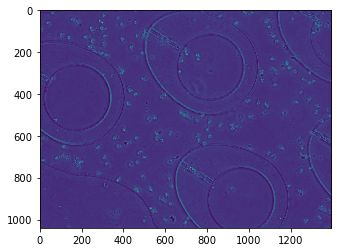

In [6]:
plt.imshow(seq[0,10,1,...])

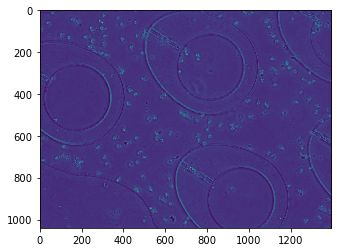

In [7]:
 plt.imshow(seq[1,10,1,...])

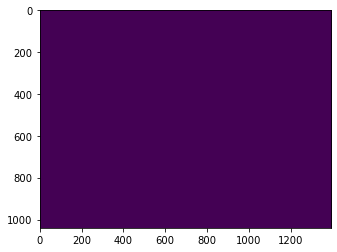

In [8]:
plt.imshow(seq[1,10,1,...]-seq[0,10,1,...])

In [9]:
# The first dimension appears to contain duplicate images

# just create a time series of the egg chamber for testing now
im=seq[0,:,1,...]

# Drift correction

In [10]:
shifts = stabilize_getshifts(im)
newim = stabilize_apply_shifts(im, shifts)

# Crop to region where all images overlap and compute temporal median

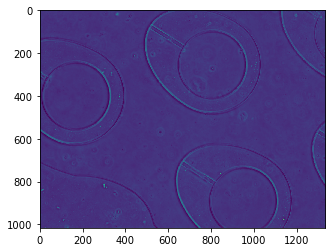

In [13]:
cropped = stabilize_crop_to_overlap(newim)
cropped_median = np.median(cropped, axis=0)
plt.imshow(cropped_median)

# Detect chambers using Hough transform

In [14]:
label_im = detect_circles(cropped_median)

found circles [[[945.5 890.5 166.8]
  [800.5 255.5 167.9]
  [163.5 396.5 163.5]]]


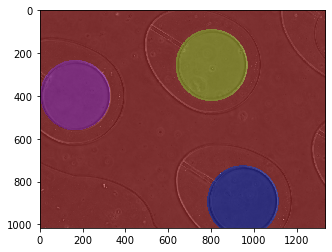

In [15]:
plt.imshow(label2rgb(label_im,cropped_median/cropped_median.max()))

# Cell detection and pre-processing for intensity measurements
note that the values seem to contain some outliers that throw off the automated intensity scaling. Note the difference in automated scaling after applying a gaussian.

Approach: 

* get a first background estimate based on the minimum per pixel over time
* for a single timepoint: apply some smoothing and subtract background
* apply otsu to find cells
* get a per-frame background intensity estimate by taking the median of the intensity in the area outside of the dilated cell mask
* subtract per-frame background intensity


If there are multiple fluorescence channels these steps will have to be done for each channel, except for thresholding which should be done on the DAPI channel.


In [16]:
# stabilize whole sequecnce
import numpy as np
stabseq = stabilize_apply_shifts(seq[0,:,...], shifts)
stabseq = stabilize_crop_to_overlap(stabseq)

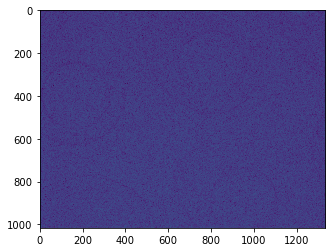

In [17]:
#median_cells = 
plt.imshow(np.min(stabseq[:,0,...], axis=0), vmin=200, vmax=700)

In [18]:
background = skimage.filters.gaussian(np.min(stabseq[:,0,...], axis=0))
#background = np.min(stabseq[:,0,...], axis=0)

In [19]:
cells = stabseq[70,0,...]


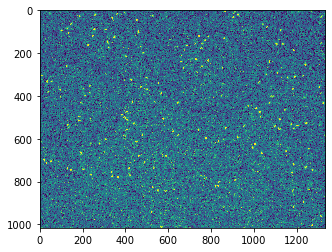

In [20]:
plt.imshow(cells,  interpolation='none', vmin=300, vmax=500)

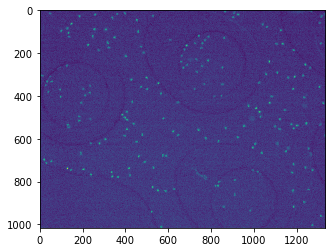

In [21]:
smoothed_cells = skimage.filters.gaussian(cells)
plt.imshow(smoothed_cells)

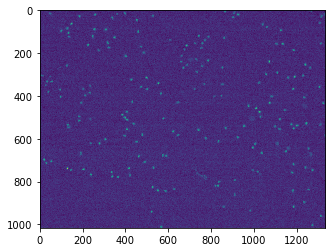

In [22]:
bgcorr = smoothed_cells - background
plt.imshow(bgcorr)

0.0013386773927190334

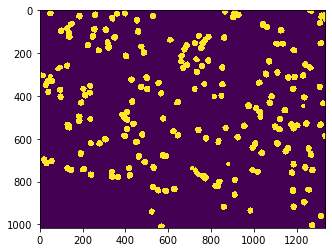

In [23]:

th = skimage.filters.threshold_otsu(bgcorr)

# TODO prevent getting the wrong threshold when there are no cells !
# set some minimum
cellmask = bgcorr > th
dilated_mask = skimage.morphology.dilation(cellmask, skimage.morphology.disk(10))
plt.imshow(dilated_mask)
bg_this_frame = np.median(bgcorr[~dilated_mask])
final_bgcorr = bgcorr - bg_this_frame
np.median(final_bgcorr[cellmask])

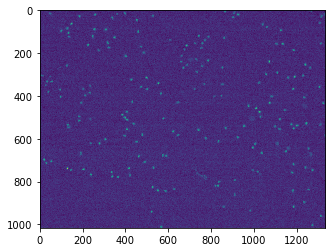

In [24]:
plt.imshow(final_bgcorr)

In [25]:
stabseq.shape

(97, 2, 1016, 1334)

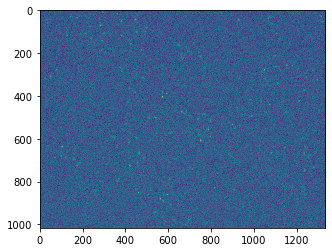

In [26]:
plt.imshow(stabseq[10,0,...])

In [27]:
stabseq.shape

(97, 2, 1016, 1334)

In [29]:
for tp, im in enumerate(stabseq):
    print(i, im.shape)
    for ch, ch_im in enumerate(im):
        print(ch, ch_im.shape)

96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0 (1016, 1334)
1 (1016, 1334)
96 (2, 1016, 1334)
0

[(0, <matplotlib.image.AxesImage at 0x1cb9b4044a8>),
 (1, <matplotlib.image.AxesImage at 0x1cb9b6d8780>),
 (2, <matplotlib.image.AxesImage at 0x1cb9b6d85c0>),
 (3, <matplotlib.image.AxesImage at 0x1cb9b6d8400>),
 (4, <matplotlib.image.AxesImage at 0x1cb9b6d8080>),
 (5, <matplotlib.image.AxesImage at 0x1cb9b60ad30>),
 (6, <matplotlib.image.AxesImage at 0x1cb9b60aba8>),
 (7, <matplotlib.image.AxesImage at 0x1cb9b60a6d8>),
 (8, <matplotlib.image.AxesImage at 0x1cb9b60a4e0>),
 (9, <matplotlib.image.AxesImage at 0x1cb9b60a5c0>),
 (10, <matplotlib.image.AxesImage at 0x1cb9b603f60>),
 (11, <matplotlib.image.AxesImage at 0x1cb9b603fd0>),
 (12, <matplotlib.image.AxesImage at 0x1cb9b6039b0>),
 (13, <matplotlib.image.AxesImage at 0x1cb9b603588>),
 (14, <matplotlib.image.AxesImage at 0x1cb9b603710>),
 (15, <matplotlib.image.AxesImage at 0x1cb9b603240>),
 (16, <matplotlib.image.AxesImage at 0x1cb9b5f6f28>),
 (17, <matplotlib.image.AxesImage at 0x1cb9b5f6e80>),
 (18, <matplotlib.image.AxesImage at 0

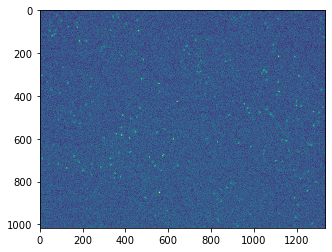

In [36]:
list(map(lambda x: (x[0], plt.imshow(x[1][0,...])), enumerate(stabseq)))